# Sensitivity Analysis: Cinema Showtime Optimization

This notebook performs sensitivity analysis on the showtime optimization model to understand:
1. How ticket price changes affect revenue
2. Impact of buffer time between shows
3. Effect of maximum showings per movie per day
4. Impact of demand variations
5. Screen capacity constraints
6. Operating hours sensitivity

In [1]:
import gurobipy as gp
from gurobipy import GRB
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import datetime as dt
import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

## Load Baseline Results and Data

In [2]:
# Load baseline results
results_dir = Path("results")

baseline_schedule = pd.read_csv(results_dir / "baseline_schedule.csv")
baseline_realized = pd.read_csv(results_dir / "baseline_realized.csv")
baseline_summary = pd.read_csv(results_dir / "baseline_summary.csv")
baseline_params = pd.read_csv(results_dir / "baseline_parameters.csv")
movie_data = pd.read_csv(results_dir / "movie_data.csv")
demand_data = pd.read_csv(results_dir / "demand_data.csv")

print("Baseline Results Loaded:")
print("="*60)
for _, row in baseline_summary.iterrows():
    print(f"{row['metric']}: {row['value']:,.2f}")

Baseline Results Loaded:
total_revenue: 733,905.90
total_showings: 35.00
total_tickets_sold: 64,890.00
num_movies_scheduled: 28.00
num_screens_used: 7.00
avg_showings_per_movie: 35.00
avg_tickets_per_showing: 463.50
capacity_utilization: 2.21


## Setup: Import Model Creation Function

In [3]:
# Theater configuration
NUM_SCREENS = 19
SCREENS = [f"Screen_{i}" for i in range(1, NUM_SCREENS+1)]
SCREEN_CAPACITIES = {s: 210 for s in SCREENS[:19]}
SCREEN_CAPACITIES["Screen_19"] = 600

DAYS = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]

# Get baseline parameters
def get_param(name):
    return baseline_params[baseline_params['parameter'] == name]['value'].values[0]

BASELINE_TICKET_PRICE = get_param('ticket_price')
BASELINE_BUFFER_MIN = get_param('buffer_min')
BASELINE_MAX_SHOWINGS = int(get_param('max_showings_per_movie_per_day'))
BASELINE_OPERATING_HOURS = get_param('operating_hours_per_day')

print(f"Baseline Parameters:")
print(f"  Ticket Price: ${BASELINE_TICKET_PRICE:.2f}")
print(f"  Buffer Time: {BASELINE_BUFFER_MIN:.0f} minutes")
print(f"  Max Showings/Movie/Day: {BASELINE_MAX_SHOWINGS}")
print(f"  Operating Hours: {BASELINE_OPERATING_HOURS:.1f} hours")

Baseline Parameters:
  Ticket Price: $11.31
  Buffer Time: 15 minutes
  Max Showings/Movie/Day: 5
  Operating Hours: 12.0 hours


In [4]:
# Prepare data structures
movie_ids = movie_data['movie_id'].tolist()
runtimes = dict(zip(movie_data['movie_id'], movie_data['runtime']))

# Create demand dictionary from loaded data
demand = {}
for _, row in demand_data.iterrows():
    demand[(row['movie_id'], row['day'])] = row['demand']

print(f"\nData Loaded:")
print(f"  Movies: {len(movie_ids)}")
print(f"  Total demand entries: {len(demand)}")


Data Loaded:
  Movies: 4
  Total demand entries: 28


In [5]:
def createModel(runtimes, demand, ticket_price, max_showings_per_day, operating_min_per_day, 
                screen_capacity, movie_ids, days, screens, buffer_min, verbose=False):
    """
    Create optimization model for cinema showtime scheduling
    """
    m = gp.Model("CinemaShowtimeScheduling")
    if not verbose:
        m.Params.OutputFlag = 0
    
    # Decision variables
    x = m.addVars(movie_ids, days, screens, vtype=GRB.INTEGER, lb=0, name="x")
    r = m.addVars(movie_ids, days, vtype=GRB.CONTINUOUS, lb=0.0, name="r")
    s = m.addVars(movie_ids, days, vtype=GRB.BINARY, name="s")
    
    # Objective: maximize total revenue
    m.setObjective(
        gp.quicksum(ticket_price * r[i, d] for i in movie_ids for d in days),
        GRB.MAXIMIZE
    )
    
    # Constraints
    # 1) Screen time constraint
    for d in days:
        for j in screens:
            m.addConstr(
                gp.quicksum(x[i, d, j] * (runtimes[i] + buffer_min) for i in movie_ids)
                <= operating_min_per_day[d],
                name=f"Time_{d}_{j}"
            )
    
    # 2) Capacity constraint
    for i in movie_ids:
        for d in days:
            m.addConstr(
                r[i, d] <= gp.quicksum(x[i, d, j] * screen_capacity[j] for j in screens),
                name=f"Capacity_{i}_{d}"
            )
    
    # 3) Demand constraint
    for i in movie_ids:
        for d in days:
            demand_id = demand.get((i, d), 0)
            m.addConstr(r[i, d] <= demand_id, name=f"Demand_{i}_{d}")
    
    # 4) Frequency and schedule linking
    for i in movie_ids:
        for d in days:
            m.addConstr(
                gp.quicksum(x[i, d, j] for j in screens)
                <= max_showings_per_day * s[i, d],
                name=f"FreqLimit_{i}_{d}"
            )
    
    return m, x, r, s

def run_optimization(runtimes, demand, ticket_price, max_showings_per_day, 
                     operating_min_per_day, screen_capacity, movie_ids, days, 
                     screens, buffer_min, verbose=False):
    """
    Run optimization and extract key metrics
    """
    m, x, r, s = createModel(runtimes, demand, ticket_price, max_showings_per_day,
                             operating_min_per_day, screen_capacity, movie_ids, 
                             days, screens, buffer_min, verbose)
    m.optimize()
    
    if m.Status == GRB.OPTIMAL:
        total_revenue = m.objVal
        total_tickets = sum(r[i, d].X for i in movie_ids for d in days)
        total_showings = sum(x[i, d, j].X for i in movie_ids for d in days for j in screens)
        
        return {
            'revenue': total_revenue,
            'tickets': total_tickets,
            'showings': total_showings,
            'status': 'Optimal'
        }
    else:
        return {
            'revenue': 0,
            'tickets': 0,
            'showings': 0,
            'status': f'Status_{m.Status}'
        }

print("Model functions defined successfully!")

Model functions defined successfully!


## 1. Ticket Price Sensitivity Analysis

In [6]:
# Test different ticket prices
price_range = np.arange(8, 18, 0.5)
price_results = []

print("Running ticket price sensitivity analysis...")
operating_min = {day: BASELINE_OPERATING_HOURS * 60 for day in DAYS}

for price in price_range:
    result = run_optimization(
        runtimes, demand, price, BASELINE_MAX_SHOWINGS,
        operating_min, SCREEN_CAPACITIES, movie_ids, DAYS, SCREENS,
        BASELINE_BUFFER_MIN, verbose=False
    )
    price_results.append({
        'ticket_price': price,
        'revenue': result['revenue'],
        'tickets': result['tickets'],
        'showings': result['showings']
    })
    print(f"  Price ${price:.2f}: Revenue ${result['revenue']:,.2f}")

price_df = pd.DataFrame(price_results)
print("\nTicket price analysis complete!")

Running ticket price sensitivity analysis...
Set parameter Username
Set parameter LicenseID to value 2737040
Academic license - for non-commercial use only - expires 2026-11-13
  Price $8.00: Revenue $519,120.00
  Price $8.50: Revenue $551,565.00
  Price $9.00: Revenue $584,010.00
  Price $9.50: Revenue $616,455.00
  Price $10.00: Revenue $648,900.00
  Price $10.50: Revenue $681,345.00
  Price $11.00: Revenue $713,790.00
  Price $11.50: Revenue $746,235.00
  Price $12.00: Revenue $778,680.00
  Price $12.50: Revenue $811,125.00
  Price $13.00: Revenue $843,570.00
  Price $13.50: Revenue $876,015.00
  Price $14.00: Revenue $908,460.00
  Price $14.50: Revenue $940,905.00
  Price $15.00: Revenue $973,350.00
  Price $15.50: Revenue $1,005,795.00
  Price $16.00: Revenue $1,038,240.00
  Price $16.50: Revenue $1,070,685.00
  Price $17.00: Revenue $1,103,130.00
  Price $17.50: Revenue $1,135,575.00

Ticket price analysis complete!


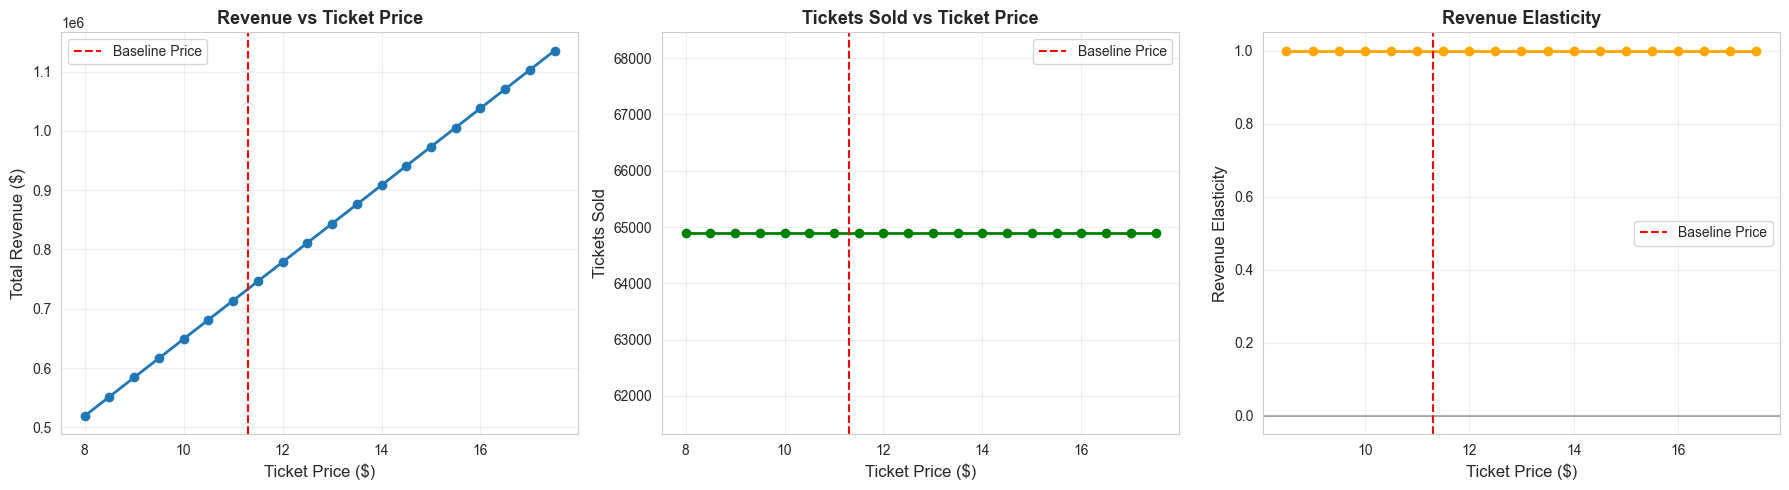

In [7]:
# Visualize ticket price sensitivity
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Revenue vs Price
axes[0].plot(price_df['ticket_price'], price_df['revenue'], marker='o', linewidth=2)
axes[0].axvline(BASELINE_TICKET_PRICE, color='red', linestyle='--', label='Baseline Price')
axes[0].set_xlabel('Ticket Price ($)', fontsize=12)
axes[0].set_ylabel('Total Revenue ($)', fontsize=12)
axes[0].set_title('Revenue vs Ticket Price', fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Tickets Sold vs Price
axes[1].plot(price_df['ticket_price'], price_df['tickets'], marker='o', linewidth=2, color='green')
axes[1].axvline(BASELINE_TICKET_PRICE, color='red', linestyle='--', label='Baseline Price')
axes[1].set_xlabel('Ticket Price ($)', fontsize=12)
axes[1].set_ylabel('Tickets Sold', fontsize=12)
axes[1].set_title('Tickets Sold vs Ticket Price', fontsize=13, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Price Elasticity
price_df['pct_change_price'] = price_df['ticket_price'].pct_change() * 100
price_df['pct_change_revenue'] = price_df['revenue'].pct_change() * 100
price_df['elasticity'] = price_df['pct_change_revenue'] / price_df['pct_change_price']

axes[2].plot(price_df['ticket_price'][1:], price_df['elasticity'][1:], marker='o', linewidth=2, color='orange')
axes[2].axhline(0, color='black', linestyle='-', alpha=0.3)
axes[2].axvline(BASELINE_TICKET_PRICE, color='red', linestyle='--', label='Baseline Price')
axes[2].set_xlabel('Ticket Price ($)', fontsize=12)
axes[2].set_ylabel('Revenue Elasticity', fontsize=12)
axes[2].set_title('Revenue Elasticity', fontsize=13, fontweight='bold')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(results_dir / 'sensitivity_ticket_price.png', dpi=300, bbox_inches='tight')
plt.show()

## 2. Buffer Time Sensitivity Analysis

In [8]:
# Test different buffer times
buffer_range = [0, 5, 10, 15, 20, 25, 30]
buffer_results = []

print("Running buffer time sensitivity analysis...")

for buffer in buffer_range:
    result = run_optimization(
        runtimes, demand, BASELINE_TICKET_PRICE, BASELINE_MAX_SHOWINGS,
        operating_min, SCREEN_CAPACITIES, movie_ids, DAYS, SCREENS,
        buffer, verbose=False
    )
    buffer_results.append({
        'buffer_min': buffer,
        'revenue': result['revenue'],
        'tickets': result['tickets'],
        'showings': result['showings']
    })
    print(f"  Buffer {buffer} min: Revenue ${result['revenue']:,.2f}, Showings: {result['showings']:.0f}")

buffer_df = pd.DataFrame(buffer_results)
print("\nBuffer time analysis complete!")

Running buffer time sensitivity analysis...
  Buffer 0 min: Revenue $795,658.50, Showings: 140
  Buffer 5 min: Revenue $764,782.20, Showings: 140
  Buffer 10 min: Revenue $733,905.90, Showings: 140
  Buffer 15 min: Revenue $733,905.90, Showings: 140
  Buffer 20 min: Revenue $703,029.60, Showings: 140
  Buffer 25 min: Revenue $703,029.60, Showings: 140
  Buffer 30 min: Revenue $672,153.30, Showings: 140

Buffer time analysis complete!


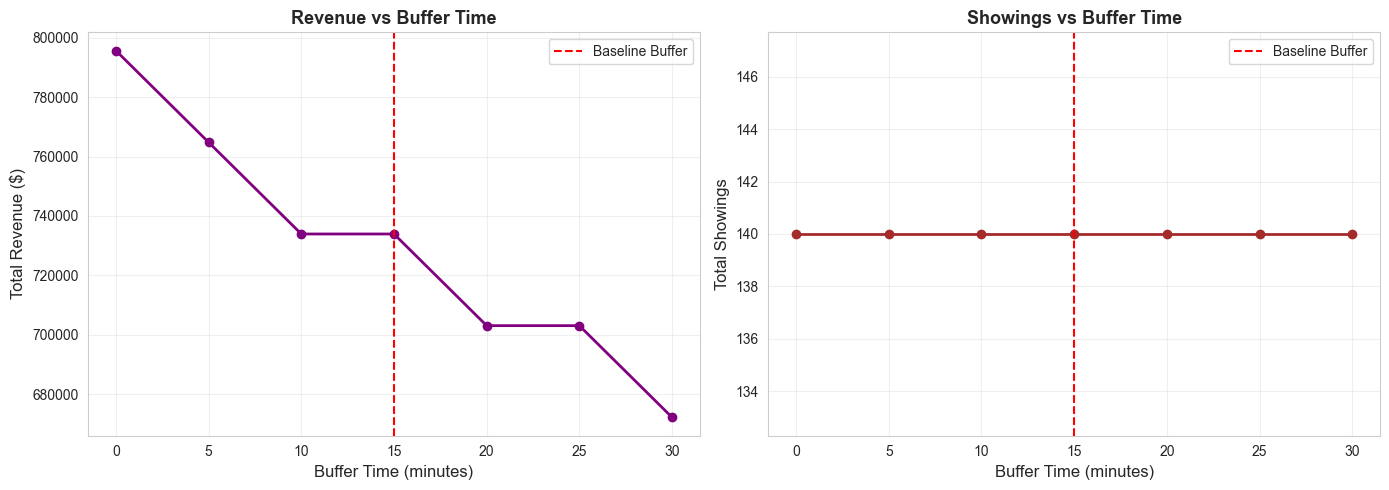

In [9]:
# Visualize buffer time sensitivity
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Revenue vs Buffer Time
axes[0].plot(buffer_df['buffer_min'], buffer_df['revenue'], marker='o', linewidth=2, color='purple')
axes[0].axvline(BASELINE_BUFFER_MIN, color='red', linestyle='--', label='Baseline Buffer')
axes[0].set_xlabel('Buffer Time (minutes)', fontsize=12)
axes[0].set_ylabel('Total Revenue ($)', fontsize=12)
axes[0].set_title('Revenue vs Buffer Time', fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Showings vs Buffer Time
axes[1].plot(buffer_df['buffer_min'], buffer_df['showings'], marker='o', linewidth=2, color='brown')
axes[1].axvline(BASELINE_BUFFER_MIN, color='red', linestyle='--', label='Baseline Buffer')
axes[1].set_xlabel('Buffer Time (minutes)', fontsize=12)
axes[1].set_ylabel('Total Showings', fontsize=12)
axes[1].set_title('Showings vs Buffer Time', fontsize=13, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(results_dir / 'sensitivity_buffer_time.png', dpi=300, bbox_inches='tight')
plt.show()

## 3. Maximum Showings Per Movie Sensitivity

In [10]:
# Test different max showings constraints
max_showings_range = [1, 2, 3, 4, 5, 6, 7, 8, 10, 15]
showings_results = []

print("Running max showings sensitivity analysis...")

for max_show in max_showings_range:
    result = run_optimization(
        runtimes, demand, BASELINE_TICKET_PRICE, max_show,
        operating_min, SCREEN_CAPACITIES, movie_ids, DAYS, SCREENS,
        BASELINE_BUFFER_MIN, verbose=False
    )
    showings_results.append({
        'max_showings': max_show,
        'revenue': result['revenue'],
        'tickets': result['tickets'],
        'showings': result['showings']
    })
    print(f"  Max Showings {max_show}: Revenue ${result['revenue']:,.2f}")

showings_df = pd.DataFrame(showings_results)
print("\nMax showings analysis complete!")

Running max showings sensitivity analysis...
  Max Showings 1: Revenue $190,008.00
  Max Showings 2: Revenue $380,016.00
  Max Showings 3: Revenue $508,271.40
  Max Showings 4: Revenue $605,650.50
  Max Showings 5: Revenue $733,905.90
  Max Showings 6: Revenue $831,285.00
  Max Showings 7: Revenue $959,540.40
  Max Showings 8: Revenue $1,056,919.50
  Max Showings 10: Revenue $1,276,084.68
  Max Showings 15: Revenue $1,604,391.36

Max showings analysis complete!


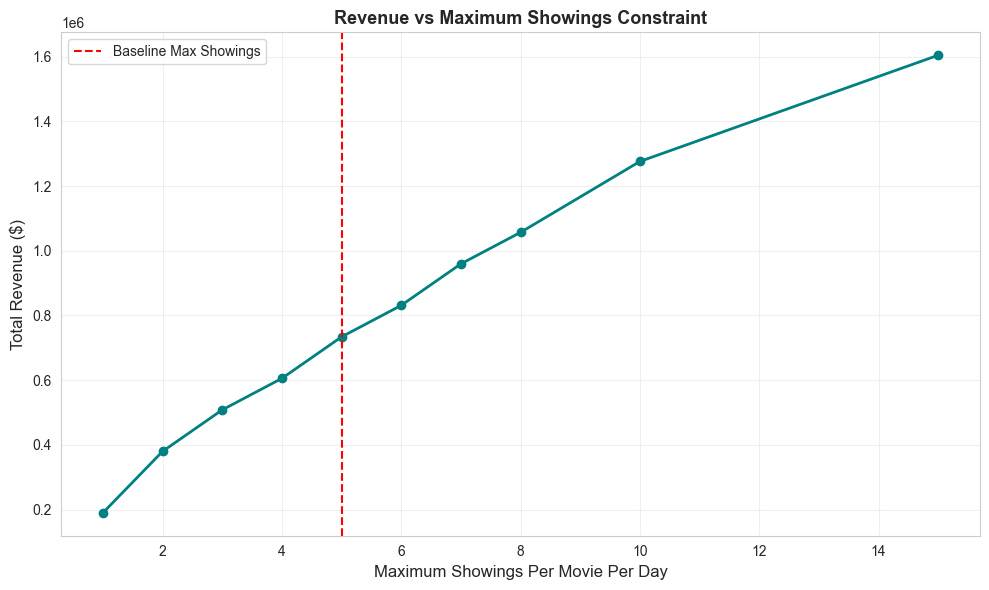

In [11]:
# Visualize max showings sensitivity
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(showings_df['max_showings'], showings_df['revenue'], marker='o', linewidth=2, color='teal')
ax.axvline(BASELINE_MAX_SHOWINGS, color='red', linestyle='--', label='Baseline Max Showings')
ax.set_xlabel('Maximum Showings Per Movie Per Day', fontsize=12)
ax.set_ylabel('Total Revenue ($)', fontsize=12)
ax.set_title('Revenue vs Maximum Showings Constraint', fontsize=13, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(results_dir / 'sensitivity_max_showings.png', dpi=300, bbox_inches='tight')
plt.show()

## 4. Demand Sensitivity Analysis

In [12]:
# Test different demand multipliers
demand_multipliers = [0.5, 0.75, 1.0, 1.25, 1.5, 2.0, 3.0]
demand_results = []

print("Running demand sensitivity analysis...")

for multiplier in demand_multipliers:
    # Scale demand
    scaled_demand = {key: int(value * multiplier) for key, value in demand.items()}
    
    result = run_optimization(
        runtimes, scaled_demand, BASELINE_TICKET_PRICE, BASELINE_MAX_SHOWINGS,
        operating_min, SCREEN_CAPACITIES, movie_ids, DAYS, SCREENS,
        BASELINE_BUFFER_MIN, verbose=False
    )
    demand_results.append({
        'demand_multiplier': multiplier,
        'revenue': result['revenue'],
        'tickets': result['tickets'],
        'showings': result['showings']
    })
    print(f"  Demand {multiplier}x: Revenue ${result['revenue']:,.2f}")

demand_sens_df = pd.DataFrame(demand_results)
print("\nDemand analysis complete!")

Running demand sensitivity analysis...
  Demand 0.5x: Revenue $727,436.58
  Demand 0.75x: Revenue $733,905.90
  Demand 1.0x: Revenue $733,905.90
  Demand 1.25x: Revenue $733,905.90
  Demand 1.5x: Revenue $733,905.90
  Demand 2.0x: Revenue $733,905.90
  Demand 3.0x: Revenue $733,905.90

Demand analysis complete!


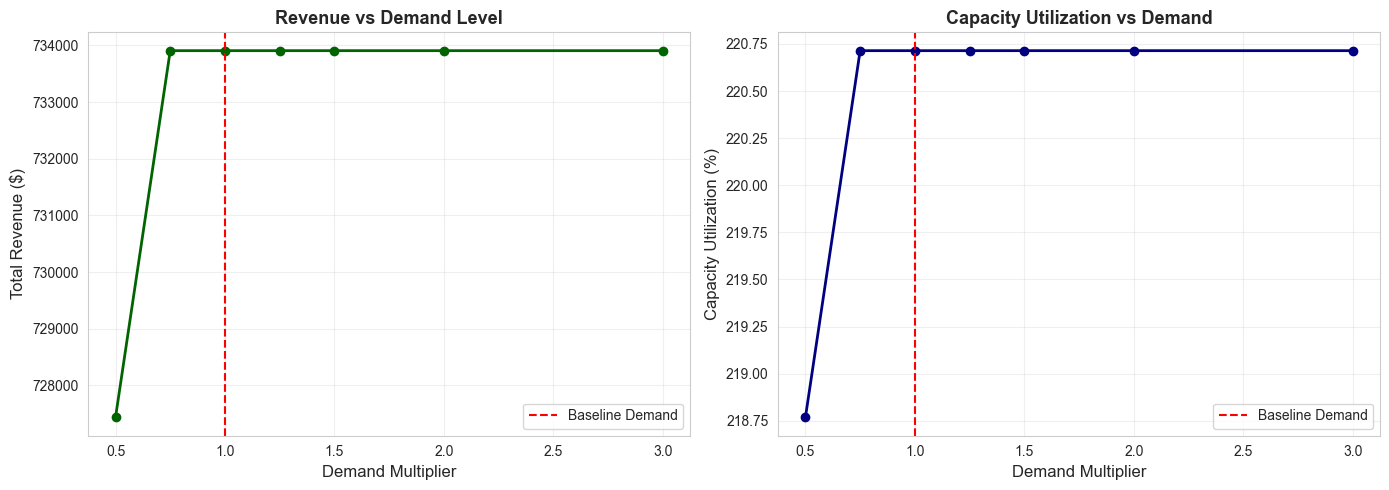

In [13]:
# Visualize demand sensitivity
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Revenue vs Demand
axes[0].plot(demand_sens_df['demand_multiplier'], demand_sens_df['revenue'], 
             marker='o', linewidth=2, color='darkgreen')
axes[0].axvline(1.0, color='red', linestyle='--', label='Baseline Demand')
axes[0].set_xlabel('Demand Multiplier', fontsize=12)
axes[0].set_ylabel('Total Revenue ($)', fontsize=12)
axes[0].set_title('Revenue vs Demand Level', fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Capacity Utilization vs Demand
demand_sens_df['utilization'] = demand_sens_df['tickets'] / (demand_sens_df['showings'] * 210)
axes[1].plot(demand_sens_df['demand_multiplier'], demand_sens_df['utilization'] * 100,
             marker='o', linewidth=2, color='navy')
axes[1].axvline(1.0, color='red', linestyle='--', label='Baseline Demand')
axes[1].set_xlabel('Demand Multiplier', fontsize=12)
axes[1].set_ylabel('Capacity Utilization (%)', fontsize=12)
axes[1].set_title('Capacity Utilization vs Demand', fontsize=13, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(results_dir / 'sensitivity_demand.png', dpi=300, bbox_inches='tight')
plt.show()

## 5. Operating Hours Sensitivity

In [14]:
# Test different operating hours
hours_range = [8, 10, 12, 14, 16, 18]
hours_results = []

print("Running operating hours sensitivity analysis...")

for hours in hours_range:
    operating_min_temp = {day: hours * 60 for day in DAYS}
    
    result = run_optimization(
        runtimes, demand, BASELINE_TICKET_PRICE, BASELINE_MAX_SHOWINGS,
        operating_min_temp, SCREEN_CAPACITIES, movie_ids, DAYS, SCREENS,
        BASELINE_BUFFER_MIN, verbose=False
    )
    hours_results.append({
        'operating_hours': hours,
        'revenue': result['revenue'],
        'tickets': result['tickets'],
        'showings': result['showings']
    })
    print(f"  {hours} hours: Revenue ${result['revenue']:,.2f}")

hours_df = pd.DataFrame(hours_results)
print("\nOperating hours analysis complete!")

Running operating hours sensitivity analysis...
  8 hours: Revenue $672,153.30
  10 hours: Revenue $703,029.60
  12 hours: Revenue $733,905.90
  14 hours: Revenue $764,782.20
  16 hours: Revenue $795,658.50
  18 hours: Revenue $826,534.80

Operating hours analysis complete!


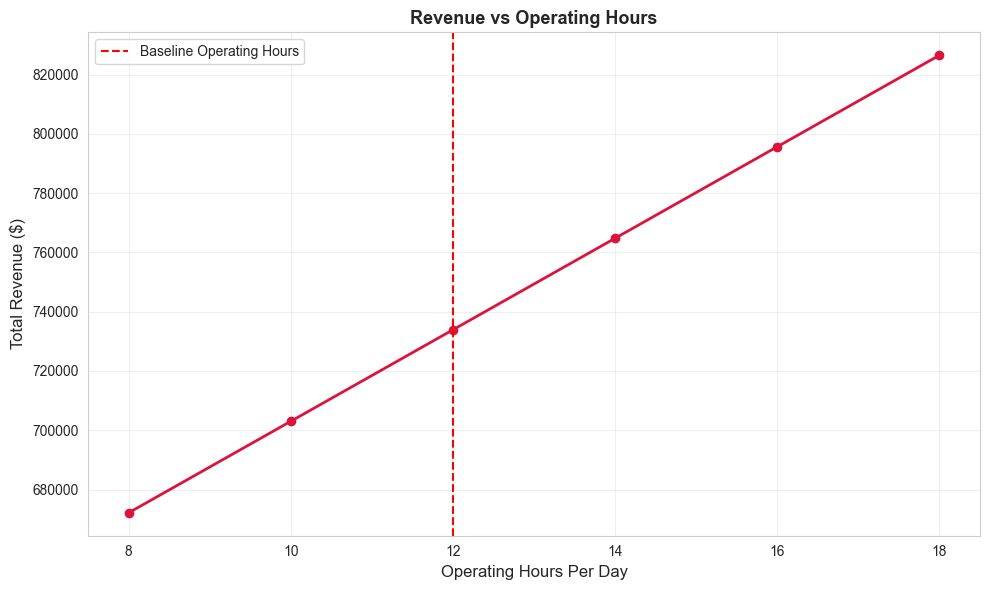

In [15]:
# Visualize operating hours sensitivity
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(hours_df['operating_hours'], hours_df['revenue'], marker='o', linewidth=2, color='crimson')
ax.axvline(BASELINE_OPERATING_HOURS, color='red', linestyle='--', label='Baseline Operating Hours')
ax.set_xlabel('Operating Hours Per Day', fontsize=12)
ax.set_ylabel('Total Revenue ($)', fontsize=12)
ax.set_title('Revenue vs Operating Hours', fontsize=13, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(results_dir / 'sensitivity_operating_hours.png', dpi=300, bbox_inches='tight')
plt.show()

## 6. Combined Sensitivity Summary

In [16]:
# Create summary table
baseline_revenue = baseline_summary[baseline_summary['metric'] == 'total_revenue']['value'].values[0]

summary_data = {
    'Parameter': [
        'Ticket Price',
        'Buffer Time',
        'Max Showings',
        'Demand Level',
        'Operating Hours'
    ],
    'Baseline Value': [
        f"${BASELINE_TICKET_PRICE:.2f}",
        f"{BASELINE_BUFFER_MIN:.0f} min",
        f"{BASELINE_MAX_SHOWINGS}",
        "1.0x",
        f"{BASELINE_OPERATING_HOURS:.1f} hrs"
    ],
    'Min Revenue': [
        f"${price_df['revenue'].min():,.2f}",
        f"${buffer_df['revenue'].min():,.2f}",
        f"${showings_df['revenue'].min():,.2f}",
        f"${demand_sens_df['revenue'].min():,.2f}",
        f"${hours_df['revenue'].min():,.2f}"
    ],
    'Max Revenue': [
        f"${price_df['revenue'].max():,.2f}",
        f"${buffer_df['revenue'].max():,.2f}",
        f"${showings_df['revenue'].max():,.2f}",
        f"${demand_sens_df['revenue'].max():,.2f}",
        f"${hours_df['revenue'].max():,.2f}"
    ],
    'Revenue Range': [
        f"{(price_df['revenue'].max() - price_df['revenue'].min()) / baseline_revenue * 100:.1f}%",
        f"{(buffer_df['revenue'].max() - buffer_df['revenue'].min()) / baseline_revenue * 100:.1f}%",
        f"{(showings_df['revenue'].max() - showings_df['revenue'].min()) / baseline_revenue * 100:.1f}%",
        f"{(demand_sens_df['revenue'].max() - demand_sens_df['revenue'].min()) / baseline_revenue * 100:.1f}%",
        f"{(hours_df['revenue'].max() - hours_df['revenue'].min()) / baseline_revenue * 100:.1f}%"
    ]
}

summary_table = pd.DataFrame(summary_data)
print("\n" + "="*80)
print("SENSITIVITY ANALYSIS SUMMARY")
print("="*80)
display(summary_table)


SENSITIVITY ANALYSIS SUMMARY


,Parameter,Baseline Value,Min Revenue,Max Revenue,Revenue Range
0,Ticket Price,$11.31,"$519,120.00","$1,135,575.00",84.0%
1,Buffer Time,15 min,"$672,153.30","$795,658.50",16.8%
2,Max Showings,5,"$190,008.00","$1,604,391.36",192.7%
3,Demand Level,1.0x,"$727,436.58","$733,905.90",0.9%
4,Operating Hours,12.0 hrs,"$672,153.30","$826,534.80",21.0%


## 7. Export Sensitivity Results

In [17]:
# Export all sensitivity results
price_df.to_csv(results_dir / 'sensitivity_ticket_price.csv', index=False)
buffer_df.to_csv(results_dir / 'sensitivity_buffer_time.csv', index=False)
showings_df.to_csv(results_dir / 'sensitivity_max_showings.csv', index=False)
demand_sens_df.to_csv(results_dir / 'sensitivity_demand.csv', index=False)
hours_df.to_csv(results_dir / 'sensitivity_operating_hours.csv', index=False)
summary_table.to_csv(results_dir / 'sensitivity_summary.csv', index=False)

print("✓ All sensitivity analysis results exported!")
print(f"  Files saved to: {results_dir}")

✓ All sensitivity analysis results exported!
  Files saved to: results


## 8. Key Insights and Recommendations

In [18]:
print("\n" + "="*80)
print("KEY INSIGHTS FROM SENSITIVITY ANALYSIS")
print("="*80)

# Find optimal ticket price
optimal_price = price_df.loc[price_df['revenue'].idxmax(), 'ticket_price']
print(f"\n1. TICKET PRICE")
print(f"   - Optimal price: ${optimal_price:.2f}")
print(f"   - Current price: ${BASELINE_TICKET_PRICE:.2f}")
if optimal_price > BASELINE_TICKET_PRICE:
    potential_gain = price_df.loc[price_df['revenue'].idxmax(), 'revenue'] - baseline_revenue
    print(f"   - Potential revenue gain: ${potential_gain:,.2f} (+{potential_gain/baseline_revenue*100:.1f}%)")

# Buffer time impact
print(f"\n2. BUFFER TIME")
zero_buffer_revenue = buffer_df[buffer_df['buffer_min'] == 0]['revenue'].values[0]
buffer_cost = zero_buffer_revenue - baseline_revenue
print(f"   - Revenue cost of {BASELINE_BUFFER_MIN:.0f} min buffer: ${buffer_cost:,.2f}")
print(f"   - Percentage impact: {buffer_cost/baseline_revenue*100:.1f}%")

# Max showings constraint
print(f"\n3. MAX SHOWINGS CONSTRAINT")
unconstrained_revenue = showings_df['revenue'].max()
constraint_cost = unconstrained_revenue - baseline_revenue
print(f"   - Current constraint: {BASELINE_MAX_SHOWINGS} showings")
print(f"   - Revenue if unconstrained: ${unconstrained_revenue:,.2f}")
print(f"   - Cost of constraint: ${constraint_cost:,.2f} ({constraint_cost/baseline_revenue*100:.1f}%)")

# Demand sensitivity
print(f"\n4. DEMAND SENSITIVITY")
demand_at_2x = demand_sens_df[demand_sens_df['demand_multiplier'] == 2.0]['revenue'].values[0]
revenue_increase = demand_at_2x - baseline_revenue
print(f"   - Revenue at 2x demand: ${demand_at_2x:,.2f}")
print(f"   - Revenue increase: ${revenue_increase:,.2f} (+{revenue_increase/baseline_revenue*100:.1f}%)")
print(f"   - Implies capacity constraints are {'BINDING' if revenue_increase/baseline_revenue < 1.0 else 'NOT BINDING'}")

# Operating hours
print(f"\n5. OPERATING HOURS")
max_hours_revenue = hours_df['revenue'].max()
hours_potential = max_hours_revenue - baseline_revenue
print(f"   - Current operating hours: {BASELINE_OPERATING_HOURS:.1f} hours")
print(f"   - Max revenue with extended hours: ${max_hours_revenue:,.2f}")
print(f"   - Potential gain: ${hours_potential:,.2f} (+{hours_potential/baseline_revenue*100:.1f}%)")

print("\n" + "="*80)


KEY INSIGHTS FROM SENSITIVITY ANALYSIS

1. TICKET PRICE
   - Optimal price: $17.50
   - Current price: $11.31
   - Potential revenue gain: $401,669.10 (+54.7%)

2. BUFFER TIME
   - Revenue cost of 15 min buffer: $61,752.60
   - Percentage impact: 8.4%

3. MAX SHOWINGS CONSTRAINT
   - Current constraint: 5 showings
   - Revenue if unconstrained: $1,604,391.36
   - Cost of constraint: $870,485.46 (118.6%)

4. DEMAND SENSITIVITY
   - Revenue at 2x demand: $733,905.90
   - Revenue increase: $0.00 (+0.0%)
   - Implies capacity constraints are BINDING

5. OPERATING HOURS
   - Current operating hours: 12.0 hours
   - Max revenue with extended hours: $826,534.80
   - Potential gain: $92,628.90 (+12.6%)

